<a href="https://colab.research.google.com/github/dolmani38/papers/blob/main/%EC%88%98%EC%A0%95-FR-Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/yuji-roh/fr-train.git

Cloning into 'fr-train'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 31 (delta 9), reused 4 (delta 0), pack-reused 0
Unpacking objects: 100% (31/31), 168.32 KiB | 2.80 MiB/s, done.


In [2]:
%cd fr-train
!pwd

/content/fr-train
/content/fr-train


# FR-Train on poisoned synthetic data

## Import libraries

In [3]:
import sys, os
import numpy as np
import math

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch

import math
import matplotlib.pyplot as plt

from argparse import Namespace

from FRTrain_arch import Generator, DiscriminatorF, DiscriminatorR, weights_init_normal, test_model

import warnings
warnings.filterwarnings("ignore")


## Load and process data (using poisoned y train label)

In [4]:
# a namespace object which contains some of the hyperparameters
opt = Namespace(num_train=2000, num_val1=200, num_val2=500, num_test=1000)

In [5]:
num_train = opt.num_train
num_val1 = opt.num_val1
num_val2 = opt.num_val2
num_test = opt.num_test

X = np.load('X_synthetic.npy') # Input features
y = np.load('y_synthetic.npy') # Original labels
y_poi = np.load('y_poi.npy') # Poisoned train labels
s1 = np.load('s1_synthetic.npy') # Sensitive features

X = torch.FloatTensor(X)
y = torch.FloatTensor(y)
y_poi = torch.FloatTensor(y_poi)
s1 = torch.FloatTensor(s1)

X_train = X[:num_train - num_val1]
y_train = y_poi[:num_train - num_val1] # Poisoned label
s1_train = s1[:num_train - num_val1]

X_val = X[num_train: num_train + num_val1]
y_val = y[num_train: num_train + num_val1]
s1_val = s1[num_train: num_train + num_val1]

# Currently not used
# X_val2 = X[num_train + num_val1 : num_train + num_val1 + num_val2]
# y_val2 = y[num_train + num_val1 : num_train + num_val1 + num_val2]
# s1_val2 = s1[num_train + num_val1 : num_train + num_val1 + num_val2]

X_test = X[num_train + num_val1 + num_val2 : num_train + num_val1 + num_val2 + num_test]
y_test = y[num_train + num_val1 + num_val2 : num_train + num_val1 + num_val2 + num_test]
s1_test = s1[num_train + num_val1 + num_val2 : num_train + num_val1 + num_val2 + num_test]

XS_train = torch.cat([X_train, s1_train.reshape((s1_train.shape[0], 1))], dim=1)
XS_val = torch.cat([X_val, s1_val.reshape((s1_val.shape[0], 1))], dim=1)
XS_test = torch.cat([X_test, s1_test.reshape((s1_test.shape[0], 1))], dim=1)

In [6]:
print("--------------------- Number of Data -------------------------" )
print(
    "Train data : %d, Validation data : %d, Test data : %d "
    % (len(y_train), len(y_val), len(y_test))
)       
print("--------------------------------------------------------------")

--------------------- Number of Data -------------------------
Train data : 1800, Validation data : 200, Test data : 1000 
--------------------------------------------------------------


In [ ]:
print(X_train.shape)
print(y_train.shape)

torch.Size([1800, 2])
torch.Size([1800])


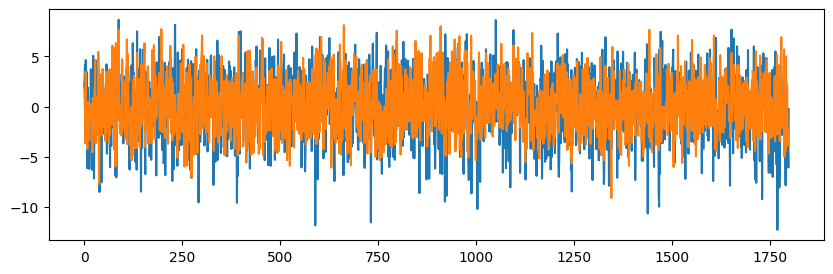

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,3))
plt.plot(X_train)

In [18]:
y_train

tensor([ 1.,  1.,  1.,  ..., -1., -1., -1.])

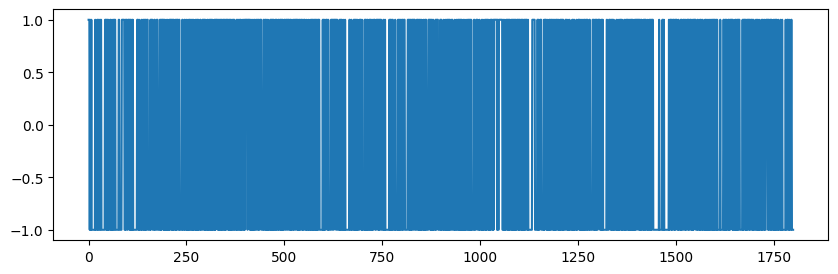

In [28]:
plt.figure(figsize=(10,3))
plt.plot(y_train)

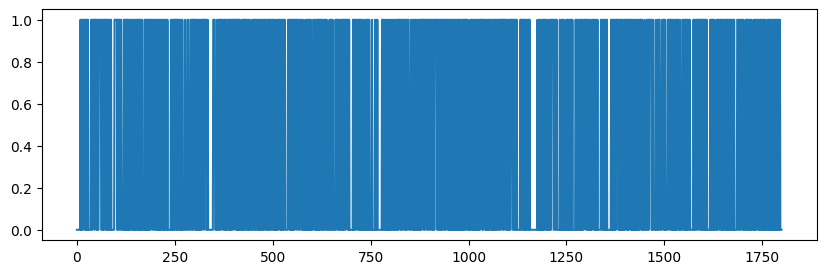

In [10]:
plt.figure(figsize=(10,3))
plt.plot(s1_train)

In [15]:
import pandas as pd
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [16]:
mi_scores = make_mi_scores(pd.DataFrame(X_train,columns=['x0','x1']), y_train, discrete_features="auto")
print(mi_scores)

x1    0.193477
x0    0.093304
Name: MI Scores, dtype: float64


In [17]:
mi_scores = make_mi_scores(pd.DataFrame(s1_train,columns=['z0']), y_train, discrete_features="auto")
print(mi_scores)

z0    0.010744
Name: MI Scores, dtype: float64


## 일반적인 deep architecture에 의한 train

### Z를 feature에 포함 안시키고 학습한 경우.

In [23]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
yy = enc.fit_transform(y_train.reshape(-1,1)).toarray()
yy

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [137]:
# building the model

from keras.models import Model   
from keras.layers import * 

inputs = Input(shape=(2,)) # input tensor
hidden1 = Dense(units=5,activation='relu')(inputs) # hidden layer 1
outputs = Dense(units=2,activation='softmax')(hidden1) # hidden layer 1

#define the model's start and end points    
model = Model(inputs, outputs)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(x=X_train.numpy(), 
        y=yy, 
        epochs=1000,
        batch_size=1000,
        verbose=1)

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_47 (Dense)            (None, 5)                 15        
                                                                 
 dense_48 (Dense)            (None, 2)                 12        
                                                                 
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
2/2 [==============================] - 1s 7ms/step - loss: 0.7294 - accuracy: 0.5272
Epoch 2/1000
2/2 [==============================] - 0s 6ms/step - loss: 0.7253 - accuracy: 0.6433
Epoch 3/1000
2/2 [==============================] - 0s 6ms/step - loss: 0.7213 - accuracy: 0.6444
Epoch 4/1000
2/2 [=========

In [138]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

predicted_y = model.predict(X_test.numpy())
predicted_yy = (predicted_y > 0.5) * 1
print('accuracy_score',accuracy_score(enc.transform(y_test.reshape(-1,1)).toarray(),predicted_yy)*100)
print('classification_report\n',classification_report(enc.transform(y_test.reshape(-1,1)).toarray(),predicted_yy))

32/32 [==============================] - 0s 1ms/step
accuracy_score 80.9
classification_report
               precision    recall  f1-score   support

           0       0.76      0.89      0.82       481
           1       0.88      0.73      0.80       519

   micro avg       0.81      0.81      0.81      1000
   macro avg       0.82      0.81      0.81      1000
weighted avg       0.82      0.81      0.81      1000
 samples avg       0.81      0.81      0.81      1000



### Disparate Impact metric

+ Disparate : 이질적인
+ https://www.giskard.ai/knowledge/how-to-test-ml-models-5-the-80-rule-to-measure-disparity
+ The proportion of a protected (minority) group with respect to an unprotected (majority) one, given a positive outcome, should be more than 80%.
+ The ratio of positive outcome probabilities, an AI model predicts, given the protected subset over the rest (unprotected) subset should be more than 80%.
+ Mathematically, we can formulate it as:

$$
DI = \frac{p(y=1|D=protected)}{p(y=1|D=unprotected)}
$$

+ 다시 말하면, unprotected (majority) = 흑인, 이라한다면,  protected (minority) = 백인 이되고, 
+ p(범인|백인) / p(범인|흑인) > 0.80 이어야 한다는 것.
+ p(승진|여자) / p(승진|남자) > 0.80
+ 가장 이상적인 것은 1 (100%) 이어야 하지만, 0.8 이상이 되면 fair 하다고 판단 하는 것!


In [133]:
s1_enc = OneHotEncoder(handle_unknown='ignore')
s1 = s1_enc.fit_transform(s1_train.reshape(-1,1)).toarray()
print(s1)
enc_s1_test = s1_enc.transform(s1_test.reshape(-1,1)).toarray()
enc_s1_test

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [139]:
Pr_y_hat_1_z_0 = sum(predicted_yy[[i for i, x in enumerate(enc_s1_test[:,0]==0) if x],0]==1)
Pr_y_hat_1_z_1 = sum(predicted_yy[[i for i, x in enumerate(enc_s1_test[:,0]==1) if x],0]==1)
print('Pr_y_hat_1_z_0',Pr_y_hat_1_z_0)
print('Pr_y_hat_1_z_1',Pr_y_hat_1_z_1)

Pr_y_hat_1_z_0 176
Pr_y_hat_1_z_1 392


In [140]:
print('s1_test가 1인 개수',sum(enc_s1_test[:,0]==1), '이때 predicted_y가 1인 개수',Pr_y_hat_1_z_1)
print('s1_test가 0인 개수',sum(enc_s1_test[:,0]==0), '이때 predicted_y가 1인 개수',Pr_y_hat_1_z_0)

s1_test가 1인 개수 573 이때 predicted_y가 1인 개수 392
s1_test가 0인 개수 427 이때 predicted_y가 1인 개수 176


In [141]:
DI = min(Pr_y_hat_1_z_0, Pr_y_hat_1_z_1) / max(Pr_y_hat_1_z_0, Pr_y_hat_1_z_1)
print('Disparate Impact', DI)

Disparate Impact 0.4489795918367347


### Z를 feature에 포함하고 학습한 경우.

In [122]:
# building the model

from keras.models import Model   
from keras.layers import * 

inputs = Input(shape=(3,)) # input tensor -> Z를 포함해서, 3개 feature가 된다.
hidden1 = Dense(units=5,activation='relu')(inputs) # hidden layer 1
outputs = Dense(units=2,activation='softmax')(hidden1) # hidden layer 1

#define the model's start and end points    
model = Model(inputs, outputs)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(x=np.concatenate((X_train.numpy(),s1_train.reshape(-1,1).numpy()),axis=1), 
        y=yy, 
        epochs=1000,
        batch_size=1000,
        verbose=1)

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_43 (Dense)            (None, 5)                 20        
                                                                 
 dense_44 (Dense)            (None, 2)                 12        
                                                                 
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
2/2 [==============================] - 1s 8ms/step - loss: 0.7689 - accuracy: 0.4089
Epoch 2/1000
2/2 [==============================] - 0s 6ms/step - loss: 0.7632 - accuracy: 0.5206
Epoch 3/1000
2/2 [==============================] - 0s 6ms/step - loss: 0.7575 - accuracy: 0.5333
Epoch 4/1000
2/2 [=========

In [123]:
predicted_y = model.predict(np.concatenate((X_test.numpy(),s1_test.reshape(-1,1).numpy()),axis=1))
predicted_yy = (predicted_y > 0.5) * 1
print('accuracy_score',accuracy_score(enc.transform(y_test.reshape(-1,1)).toarray(),predicted_yy)*100)
print('classification_report\n',classification_report(enc.transform(y_test.reshape(-1,1)).toarray(),predicted_yy))

32/32 [==============================] - 0s 1ms/step
accuracy_score 88.3
classification_report
               precision    recall  f1-score   support

           0       0.87      0.89      0.88       481
           1       0.90      0.87      0.89       519

   micro avg       0.88      0.88      0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000
 samples avg       0.88      0.88      0.88      1000



In [124]:
Pr_y_hat_1_z_0 = sum(predicted_yy[[i for i, x in enumerate(enc_s1_test[:,0]==0) if x],0]==1)
Pr_y_hat_1_z_1 = sum(predicted_yy[[i for i, x in enumerate(enc_s1_test[:,0]==1) if x],0]==1)
DI = min(Pr_y_hat_1_z_0, Pr_y_hat_1_z_1) / max(Pr_y_hat_1_z_0, Pr_y_hat_1_z_1)
print('Disparate Impact', DI)

Disparate Impact 0.23192019950124687


## Training with FR-Train

In [151]:
def train_model(train_tensors, val_tensors, test_tensors, train_opt, lambda_f, seed):
    """
      Trains FR-Train by using the classes in FRTrain_arch.py.
      
      Args:
        train_tensors: Training data.
        val_tensors: Clean validation data.
        test_tensors: Test data.
        train_opt: Options for the training. It currently contains size of validation set, 
                number of epochs, generator/discriminator update ratio, and learning rates.
        lambda_f: The tuning knob for L_2 (ref: FR-Train paper, Section 3.3).
        #lambda_r: The tuning knob for L_3 (ref: FR-Train paper, Section 3.3).
        seed: An integer value for specifying torch random seed.
        
      Returns:
        Information about the tuning knobs (lambda_f, lambda_r),
        the test accuracy of the trained model, and disparate impact of the trained model.
    """
    
    XS_train = train_tensors.XS_train
    y_train = train_tensors.y_train
    s1_train = train_tensors.s1_train
    
    XS_val = val_tensors.XS_val
    y_val = val_tensors.y_val
    s1_val = val_tensors.s1_val
    
    XS_test = test_tensors.XS_test
    y_test = test_tensors.y_test
    s1_test = test_tensors.s1_test
    
    # Saves return values here
    test_result = [] 
    
    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch
    
    # Changes the input validation data to an appropriate shape for the training
    XSY_val = torch.cat([XS_val, y_val.reshape((y_val.shape[0], 1))], dim=1)  

    # The loss values of each component will be saved in the following lists. 
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    d_f_losses = []
    #d_r_losses = []
    clean_test_result = []

    bce_loss = torch.nn.BCELoss()

    # Initializes generator and discriminator
    generator = Generator()
    discriminator_F = DiscriminatorF()
    #discriminator_R = DiscriminatorR()

    # Initializes weights
    torch.manual_seed(seed)
    generator.apply(weights_init_normal)
    discriminator_F.apply(weights_init_normal)
    #discriminator_R.apply(weights_init_normal)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)
    optimizer_D_F = torch.optim.SGD(discriminator_F.parameters(), lr=train_opt.lr_f)
    #optimizer_D_R = torch.optim.SGD(discriminator_R.parameters(), lr=train_opt.lr_r)

    XSY_val_data = XSY_val[:val]

    train_len = XS_train.shape[0]
    val_len = XSY_val.shape[0]

    # Ground truths using in Disriminator_R
    Tensor = torch.FloatTensor
    valid = Variable(Tensor(train_len, 1).fill_(1.0), requires_grad=False)
    generated = Variable(Tensor(train_len, 1).fill_(0.0), requires_grad=False)
    fake = Variable(Tensor(train_len, 1).fill_(0.0), requires_grad=False)
    clean = Variable(Tensor(val_len, 1).fill_(1.0), requires_grad=False)
    

    #r_weight = torch.ones_like(y_train, requires_grad=False).float()
    #r_ones = torch.ones_like(y_train, requires_grad=False).float()

    for epoch in range(n_epochs):

        # -------------------
        #  Forwards Generator
        # -------------------
        if epoch % k == 0 or epoch < 500:
            optimizer_G.zero_grad()

        gen_y = generator(XS_train).reshape(-1,1)
        gen_data = torch.cat([XS_train, gen_y.reshape((gen_y.shape[0], 1))], dim=1)


        # -------------------------------
        #  Trains Fairness Discriminator
        # -------------------------------

        optimizer_D_F.zero_grad()
        
        # Discriminator_F tries to distinguish the sensitive groups by using the output of the generator.
        d_f_loss = bce_loss(discriminator_F(gen_y.detach()), s1_train.reshape(-1,1))
        d_f_loss.backward()
        d_f_losses.append(d_f_loss)
        optimizer_D_F.step()
            
            
        # ---------------------------------
        #  Trains Robustness Discriminator
        # ---------------------------------
        '''
        optimizer_D_R.zero_grad()

        # Discriminator_R tries to distinguish whether the input is from the validation data or the generated data from generator.
        clean_loss =  bce_loss(discriminator_R(XSY_val_data), clean)
        poison_loss = bce_loss(discriminator_R(gen_data.detach()), fake)
        d_r_loss = 0.5 * (clean_loss + poison_loss)

        d_r_loss.backward()
        d_r_losses.append(d_r_loss)
        optimizer_D_R.step()
        '''
        
        # ---------------------
        #  Updates Generator
        # ---------------------


        if epoch < 500 :
            g_loss = 0.1 * bce_loss((F.tanh(gen_y)+1)/2, (y_train.reshape(-1,1)+1)/2)
            g_loss.backward()
            g_losses.append(g_loss)
            optimizer_G.step()
        elif epoch % k == 0:
            #r_decision = discriminator_R(gen_data)
            #r_gen = bce_loss(r_decision, generated)
            
            # ---------------------------------
            #  Re-weights using output of D_R
            # ---------------------------------
            #if epoch % 100 == 0:
            #    loss_ratio = (g_losses[-1]/d_r_losses[-1]).detach()
            #    a = 1/(1+torch.exp(-(loss_ratio-3)))
            #    b = 1-a
            #    r_weight_tmp = r_decision.detach().squeeze()
            #    r_weight = a * r_weight_tmp + b * r_ones

            f_cost = F.binary_cross_entropy(discriminator_F(gen_y), s1_train.reshape(-1,1), reduction="none").squeeze()
            g_cost = F.binary_cross_entropy_with_logits(gen_y.squeeze(), (y_train.squeeze()+1)/2, reduction="none").squeeze()

            #f_gen = torch.mean(f_cost*r_weight)
            f_gen = torch.mean(f_cost)
            #g_loss = (1-lambda_f-lambda_r) * torch.mean(g_cost*r_weight) - lambda_f * f_gen -  lambda_r * r_gen 
            g_loss = (1-lambda_f) * torch.mean(g_cost) - lambda_f * f_gen 

            g_loss.backward()
            optimizer_G.step()


        g_losses.append(g_loss)

        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [D_F loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, d_f_losses[-1], g_losses[-1])
                )

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    tmp = test_model(generator, XS_test, y_test, s1_test)
    test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    return test_result

In [152]:
train_result = []
train_tensors = Namespace(XS_train = XS_train, y_train = y_train, s1_train = s1_train)
val_tensors = Namespace(XS_val = XS_val, y_val = y_val, s1_val = s1_val) 
test_tensors = Namespace(XS_test = XS_test, y_test = y_test, s1_test = s1_test)

train_opt = Namespace(val=len(y_val), n_epochs=1000, k=5, lr_g=0.001, lr_f=0.001, lr_r=0.001)
seed = 1

lambda_f_set = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.52] # Lambda value for the fairness discriminator of FR-Train.
#lambda_r = 0.4 # Lambda value for the robustness discriminator of FR-Train.

for lambda_f in lambda_f_set:
    train_result.append(train_model(train_tensors, val_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed))

[Lambda: 0.100000] [Epoch 0/1000] [D_F loss: 0.686340] [G loss: 0.060358]
[Lambda: 0.100000] [Epoch 200/1000] [D_F loss: 0.682480] [G loss: 0.057829]
[Lambda: 0.100000] [Epoch 400/1000] [D_F loss: 0.679608] [G loss: 0.057678]
[Lambda: 0.100000] [Epoch 600/1000] [D_F loss: 0.669466] [G loss: 0.456159]
[Lambda: 0.100000] [Epoch 800/1000] [D_F loss: 0.666391] [G loss: 0.452935]
Test accuracy: 0.8199999928474426
P(y_hat=1 | z=0) = 0.283, P(y_hat=1 | z=1) = 0.527
P(y_hat=1 | y=1, z=0) = 0.714, P(y_hat=1 | y=1, z=1) = 0.691
Disparate Impact ratio = 0.537
[Lambda: 0.150000] [Epoch 0/1000] [D_F loss: 0.686340] [G loss: 0.060358]
[Lambda: 0.150000] [Epoch 200/1000] [D_F loss: 0.682480] [G loss: 0.057829]
[Lambda: 0.150000] [Epoch 400/1000] [D_F loss: 0.679608] [G loss: 0.057678]
[Lambda: 0.150000] [Epoch 600/1000] [D_F loss: 0.669815] [G loss: 0.393614]
[Lambda: 0.150000] [Epoch 800/1000] [D_F loss: 0.667658] [G loss: 0.390722]
Test accuracy: 0.8180000185966492
P(y_hat=1 | z=0) = 0.286, P(y_hat

In [153]:
train_tensors
print("-----------------------------------------------------------------------------------")
print("------------------ Training Results of FR-Train on poisoned data ------------------" )
for i in range(len(train_result)):
    print(
        "[Lambda_f: %.2f] Accuracy : %.3f, Disparate Impact : %.3f "
        % (train_result[i][0][0], train_result[i][0][1], train_result[i][0][2])
    )       
print("-----------------------------------------------------------------------------------")

-----------------------------------------------------------------------------------
------------------ Training Results of FR-Train on poisoned data ------------------
[Lambda_f: 0.10] Accuracy : 0.820, Disparate Impact : 0.537 
[Lambda_f: 0.15] Accuracy : 0.818, Disparate Impact : 0.548 
[Lambda_f: 0.20] Accuracy : 0.817, Disparate Impact : 0.564 
[Lambda_f: 0.25] Accuracy : 0.809, Disparate Impact : 0.587 
[Lambda_f: 0.30] Accuracy : 0.802, Disparate Impact : 0.606 
[Lambda_f: 0.35] Accuracy : 0.792, Disparate Impact : 0.646 
[Lambda_f: 0.40] Accuracy : 0.789, Disparate Impact : 0.678 
[Lambda_f: 0.45] Accuracy : 0.780, Disparate Impact : 0.718 
[Lambda_f: 0.52] Accuracy : 0.764, Disparate Impact : 0.774 
-----------------------------------------------------------------------------------


## RF_train에서, Fairness discriminator를 제거하고... 학습해보자

In [128]:
def train_model2(train_tensors, val_tensors, test_tensors, train_opt, lambda_f, seed):
    """
      Trains FR-Train by using the classes in FRTrain_arch.py.
      
      Args:
        train_tensors: Training data.
        val_tensors: Clean validation data.
        test_tensors: Test data.
        train_opt: Options for the training. It currently contains size of validation set, 
                number of epochs, generator/discriminator update ratio, and learning rates.
        lambda_f: The tuning knob for L_2 (ref: FR-Train paper, Section 3.3).
        #lambda_r: The tuning knob for L_3 (ref: FR-Train paper, Section 3.3).
        seed: An integer value for specifying torch random seed.
        
      Returns:
        Information about the tuning knobs (lambda_f, lambda_r),
        the test accuracy of the trained model, and disparate impact of the trained model.
    """
    
    XS_train = train_tensors.XS_train
    y_train = train_tensors.y_train
    s1_train = train_tensors.s1_train
    
    XS_val = val_tensors.XS_val
    y_val = val_tensors.y_val
    s1_val = val_tensors.s1_val
    
    XS_test = test_tensors.XS_test
    y_test = test_tensors.y_test
    s1_test = test_tensors.s1_test
    
    # Saves return values here
    test_result = [] 
    
    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch
    
    # Changes the input validation data to an appropriate shape for the training
    XSY_val = torch.cat([XS_val, y_val.reshape((y_val.shape[0], 1))], dim=1)  

    # The loss values of each component will be saved in the following lists. 
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    #d_f_losses = []
    #d_r_losses = []
    clean_test_result = []

    bce_loss = torch.nn.BCELoss()

    # Initializes generator and discriminator
    generator = Generator()
    #discriminator_F = DiscriminatorF()
    #discriminator_R = DiscriminatorR()

    # Initializes weights
    torch.manual_seed(seed)
    generator.apply(weights_init_normal)
    #discriminator_F.apply(weights_init_normal)
    #discriminator_R.apply(weights_init_normal)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)
    #optimizer_D_F = torch.optim.SGD(discriminator_F.parameters(), lr=train_opt.lr_f)
    #optimizer_D_R = torch.optim.SGD(discriminator_R.parameters(), lr=train_opt.lr_r)

    XSY_val_data = XSY_val[:val]

    train_len = XS_train.shape[0]
    val_len = XSY_val.shape[0]

    # Ground truths using in Disriminator_R
    Tensor = torch.FloatTensor
    valid = Variable(Tensor(train_len, 1).fill_(1.0), requires_grad=False)
    generated = Variable(Tensor(train_len, 1).fill_(0.0), requires_grad=False)
    fake = Variable(Tensor(train_len, 1).fill_(0.0), requires_grad=False)
    clean = Variable(Tensor(val_len, 1).fill_(1.0), requires_grad=False)
    

    #r_weight = torch.ones_like(y_train, requires_grad=False).float()
    #r_ones = torch.ones_like(y_train, requires_grad=False).float()

    for epoch in range(n_epochs):

        # -------------------
        #  Forwards Generator
        # -------------------
        if epoch % k == 0 or epoch < 500:
            optimizer_G.zero_grad()

        gen_y = generator(XS_train).reshape(-1,1)
        gen_data = torch.cat([XS_train, gen_y.reshape((gen_y.shape[0], 1))], dim=1)


        # -------------------------------
        #  Trains Fairness Discriminator
        # -------------------------------
        '''
        optimizer_D_F.zero_grad()
        
        # Discriminator_F tries to distinguish the sensitive groups by using the output of the generator.
        d_f_loss = bce_loss(discriminator_F(gen_y.detach()), s1_train.reshape(-1,1))
        d_f_loss.backward()
        d_f_losses.append(d_f_loss)
        optimizer_D_F.step()
        ''' 
            
        # ---------------------------------
        #  Trains Robustness Discriminator
        # ---------------------------------
        '''
        optimizer_D_R.zero_grad()

        # Discriminator_R tries to distinguish whether the input is from the validation data or the generated data from generator.
        clean_loss =  bce_loss(discriminator_R(XSY_val_data), clean)
        poison_loss = bce_loss(discriminator_R(gen_data.detach()), fake)
        d_r_loss = 0.5 * (clean_loss + poison_loss)

        d_r_loss.backward()
        d_r_losses.append(d_r_loss)
        optimizer_D_R.step()
        '''
        
        # ---------------------
        #  Updates Generator
        # ---------------------


        if epoch < 500 :
            g_loss = 0.1 * bce_loss((F.tanh(gen_y)+1)/2, (y_train.reshape(-1,1)+1)/2)
            g_loss.backward()
            g_losses.append(g_loss)
            optimizer_G.step()
        elif epoch % k == 0:
            #r_decision = discriminator_R(gen_data)
            #r_gen = bce_loss(r_decision, generated)
            
            # ---------------------------------
            #  Re-weights using output of D_R
            # ---------------------------------
            #if epoch % 100 == 0:
            #    loss_ratio = (g_losses[-1]/d_r_losses[-1]).detach()
            #    a = 1/(1+torch.exp(-(loss_ratio-3)))
            #    b = 1-a
            #    r_weight_tmp = r_decision.detach().squeeze()
            #    r_weight = a * r_weight_tmp + b * r_ones

            #f_cost = F.binary_cross_entropy(discriminator_F(gen_y), s1_train.reshape(-1,1), reduction="none").squeeze()
            g_cost = F.binary_cross_entropy_with_logits(gen_y.squeeze(), (y_train.squeeze()+1)/2, reduction="none").squeeze()

            #f_gen = torch.mean(f_cost*r_weight)
            #f_gen = torch.mean(f_cost)
            #g_loss = (1-lambda_f-lambda_r) * torch.mean(g_cost*r_weight) - lambda_f * f_gen -  lambda_r * r_gen 
            g_loss = (1-lambda_f) * torch.mean(g_cost) #- lambda_f * f_gen 

            g_loss.backward()
            optimizer_G.step()


        g_losses.append(g_loss)

        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, g_losses[-1])
                )

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    tmp = test_model(generator, XS_test, y_test, s1_test)
    test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    return test_result

In [129]:
train_result = []
train_tensors = Namespace(XS_train = XS_train, y_train = y_train, s1_train = s1_train)
val_tensors = Namespace(XS_val = XS_val, y_val = y_val, s1_val = s1_val) 
test_tensors = Namespace(XS_test = XS_test, y_test = y_test, s1_test = s1_test)

train_opt = Namespace(val=len(y_val), n_epochs=1000, k=5, lr_g=0.001, lr_f=0.001, lr_r=0.001)
seed = 1

lambda_f_set = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.52] # Lambda value for the fairness discriminator of FR-Train.
#lambda_r = 0.4 # Lambda value for the robustness discriminator of FR-Train.

for lambda_f in lambda_f_set:
    train_result.append(train_model2(train_tensors, val_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed))

[Lambda: 0.100000] [Epoch 0/1000] [G loss: 0.060358]
[Lambda: 0.100000] [Epoch 200/1000] [G loss: 0.057829]
[Lambda: 0.100000] [Epoch 400/1000] [G loss: 0.057678]
[Lambda: 0.100000] [Epoch 600/1000] [G loss: 0.523154]
[Lambda: 0.100000] [Epoch 800/1000] [G loss: 0.519407]
Test accuracy: 0.8240000009536743
P(y_hat=1 | z=0) = 0.272, P(y_hat=1 | z=1) = 0.541
P(y_hat=1 | y=1, z=0) = 0.693, P(y_hat=1 | y=1, z=1) = 0.709
Disparate Impact ratio = 0.503
[Lambda: 0.150000] [Epoch 0/1000] [G loss: 0.060358]
[Lambda: 0.150000] [Epoch 200/1000] [G loss: 0.057829]
[Lambda: 0.150000] [Epoch 400/1000] [G loss: 0.057678]
[Lambda: 0.150000] [Epoch 600/1000] [G loss: 0.494136]
[Lambda: 0.150000] [Epoch 800/1000] [G loss: 0.490576]
Test accuracy: 0.8230000138282776
P(y_hat=1 | z=0) = 0.274, P(y_hat=1 | z=1) = 0.541
P(y_hat=1 | y=1, z=0) = 0.693, P(y_hat=1 | y=1, z=1) = 0.709
Disparate Impact ratio = 0.506
[Lambda: 0.200000] [Epoch 0/1000] [G loss: 0.060358]
[Lambda: 0.200000] [Epoch 200/1000] [G loss: 0.

In [130]:
train_tensors
print("-----------------------------------------------------------------------------------")
print("------------------ Training Results of FR-Train on poisoned data ------------------" )
for i in range(len(train_result)):
    print(
        "[Lambda_f: %.2f] Accuracy : %.3f, Disparate Impact : %.3f "
        % (train_result[i][0][0], train_result[i][0][1], train_result[i][0][2])
    )       
print("-----------------------------------------------------------------------------------")

-----------------------------------------------------------------------------------
------------------ Training Results of FR-Train on poisoned data ------------------
[Lambda_f: 0.10] Accuracy : 0.824, Disparate Impact : 0.503 
[Lambda_f: 0.15] Accuracy : 0.823, Disparate Impact : 0.506 
[Lambda_f: 0.20] Accuracy : 0.822, Disparate Impact : 0.510 
[Lambda_f: 0.25] Accuracy : 0.822, Disparate Impact : 0.510 
[Lambda_f: 0.30] Accuracy : 0.823, Disparate Impact : 0.513 
[Lambda_f: 0.35] Accuracy : 0.823, Disparate Impact : 0.513 
[Lambda_f: 0.40] Accuracy : 0.823, Disparate Impact : 0.513 
[Lambda_f: 0.45] Accuracy : 0.825, Disparate Impact : 0.519 
[Lambda_f: 0.52] Accuracy : 0.827, Disparate Impact : 0.516 
-----------------------------------------------------------------------------------
